# Setup and Data Loading

## Disclaimer: This project proposal involves analyzing online jokes, which may contain content that could be offensive to some individuals.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import contractions
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from datasets import Dataset

In [35]:
# Downloading the dataset
# !kaggle datasets download priyamchoksi/1-million-reddit-jokes-rjokes

In [36]:
# !unzip 1-million-reddit-jokes-rjokes.zip -d dataset

In [37]:
# Loading the dataset
df = pd.read_csv('dataset/one-million-reddit-jokes.csv')
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,NaN,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,NaN,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh...,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg...,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


# Data Cleaning

In [38]:
df = df[(df['selftext'] != '[removed]')]
df = df[(df['selftext'] != '[deleted]')]
df.drop(columns=['domain', 'url'], inplace=True)

# Deleting the rows with null selftext as the number of rows is very less
df.dropna(subset=['selftext'], inplace=True)
df = df[df['selftext'] != '']

# Deleting the rows with null title as the number of rows is very less
df.dropna(subset=['title'], inplace=True)
df = df[df['title'] != '']

df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
7,post,ftbeb4,2qh72,jokes,False,1585784461,https://old.reddit.com/r/Jokes/comments/ftbeb4...,Oo..lala...,What did the French man say to the attractive ...,2
10,post,ftbahg,2qh72,jokes,False,1585784081,https://old.reddit.com/r/Jokes/comments/ftbahg...,"Yo momma's so fat, that when she went to the z...",Yo Mama,0


# Exploratory Data Analysis

In [39]:
df.columns

Index(['type', 'id', 'subreddit.id', 'subreddit.name', 'subreddit.nsfw',
       'created_utc', 'permalink', 'selftext', 'title', 'score'],
      dtype='object')

In [40]:
df.describe()

,created_utc,score
count,5.741620e+05,574162.000000
mean,1.513565e+09,227.733823
std,4.425936e+07,2142.887452
min,1.427397e+09,0.000000
25%,1.477034e+09,1.000000
50%,1.516020e+09,5.000000
75%,1.554146e+09,16.000000
max,1.585786e+09,142733.000000


In [41]:
# Check for missing values
df.isnull().sum()

type              0
id                0
subreddit.id      0
subreddit.name    0
subreddit.nsfw    0
created_utc       0
permalink         0
selftext          0
title             0
score             0
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

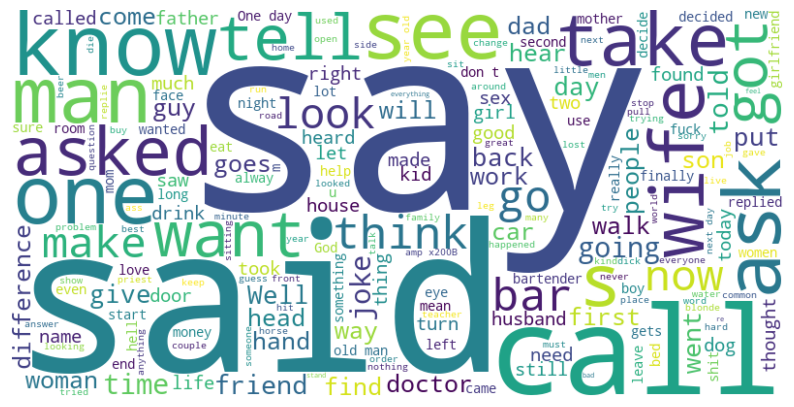

In [42]:
# Wordcloud of jokes
text = ' '.join(df['title'] + ' ' + df['selftext'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

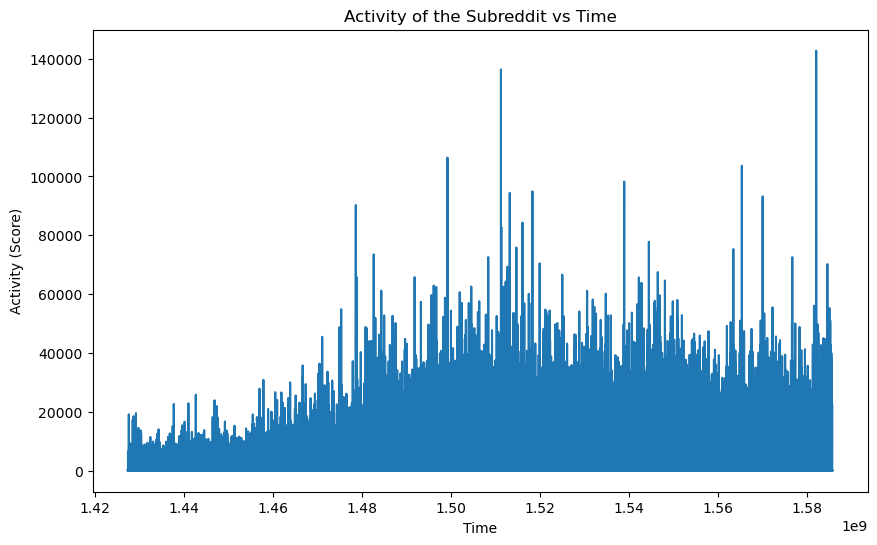

In [43]:
# Activity of the sub-reddit based on the score vs time
plt.figure(figsize=(10, 6))
sns.lineplot(x='created_utc', y='score', data=df)
plt.title('Activity of the Subreddit vs Time')
plt.xlabel('Time')
plt.ylabel('Activity (Score)')
plt.show()

In [44]:
df['length'] = df['selftext'].apply(lambda x: len(x.split())) + df['title'].apply(lambda x: len(x.split()))

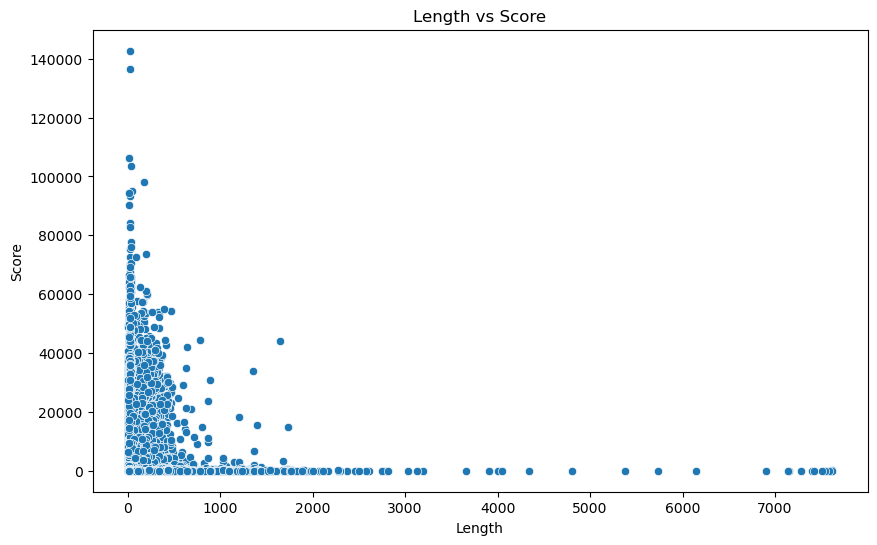

In [45]:
# Length vs Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['length'], y=df['score'])
plt.title('Length vs Score')
plt.xlabel('Length')
plt.ylabel('Score')
plt.show()

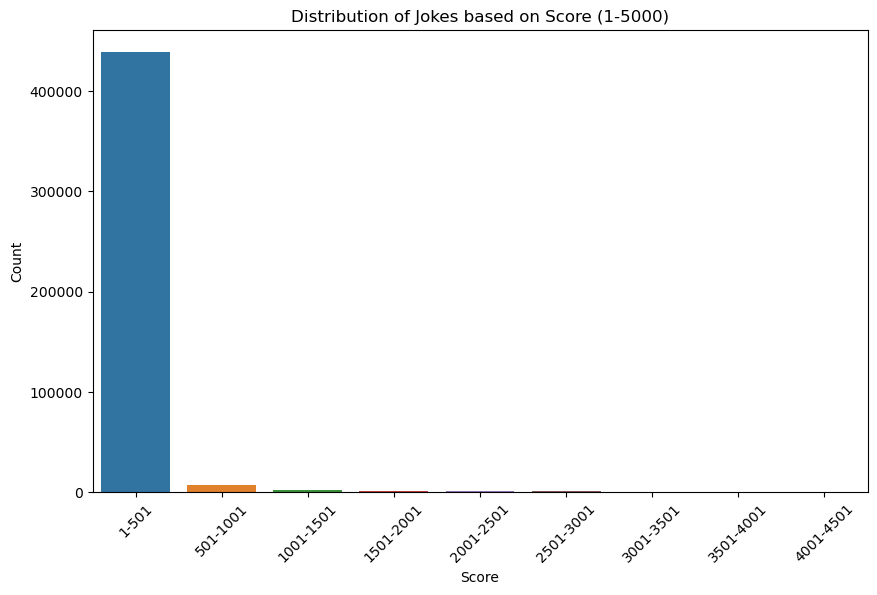

In [46]:
# Plotting the distribution of the scores of the jokes
bins = [x for x in range(1, 5000, 500)]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]


df['score_bins'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)


plt.figure(figsize=(10, 6))
sns.countplot(x='score_bins', data=df[df['score'] <= 5000])
plt.title('Distribution of Jokes based on Score (1-5000)')
plt.xticks(rotation=45)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

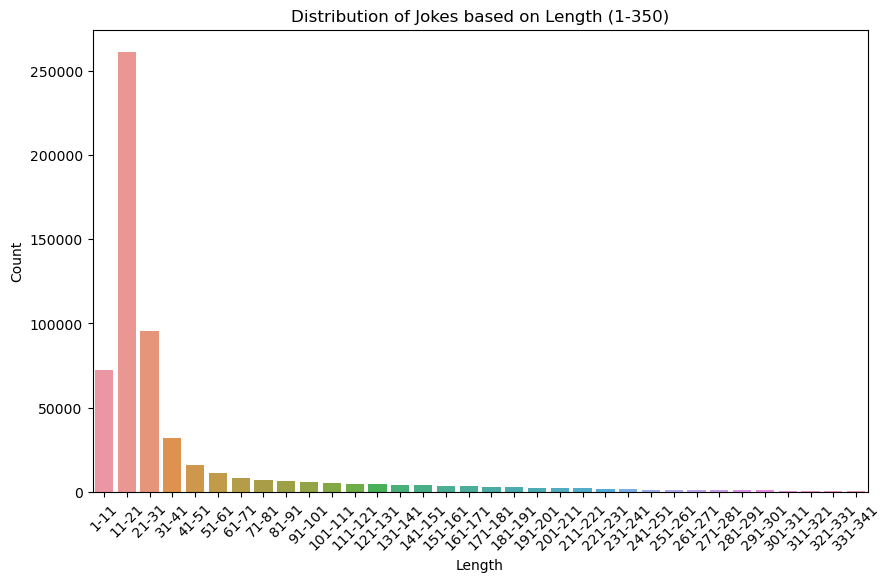

In [47]:
# Plotting the distribution of jokes based on the length of the jokes < 350
bins = [x for x in range(1, 351, 10)]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]


df['length_bins'] = pd.cut(df['length'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(x='length_bins', data=df[df['length'] <= 350])
plt.title('Distribution of Jokes based on Length (1-350)')
plt.xticks(rotation=45)
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

# Data Preparation

In [48]:
# Removing the columns: type, id, subreddit.id, subreddit.name, subreddit.nsfw
df.drop(columns=['type', 'id', 'subreddit.id', 'subreddit.name', 'subreddit.nsfw'], inplace=True)
df.head()

,created_utc,permalink,selftext,title,score,length,score_bins,length_bins
0,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2,20,1-501,11-21
1,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,It's called Google Sheets.,Did you know Google now has a platform for rec...,9,17,1-501,11-21
2,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15,24,1-501,21-31
7,1585784461,https://old.reddit.com/r/Jokes/comments/ftbeb4...,Oo..lala...,What did the French man say to the attractive ...,2,11,1-501,11-21
10,1585784081,https://old.reddit.com/r/Jokes/comments/ftbahg...,"Yo momma's so fat, that when she went to the z...",Yo Mama,0,17,NaN,11-21


## Text Cleaning

In [49]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Remove Punctuation and Special Characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Stop Words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in stop_words])
    return text

# Applying to selftext and title columns
df['title'] = df['title'].apply(clean_text)
df['selftext'] = df['selftext'].apply(clean_text)

# Saving the cleaned data
df.to_csv('dataset/cleaned_jokes.csv', index=False)

df.head()


[nltk_data] Downloading package stopwords to /Users/omkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/omkar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/omkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,created_utc,permalink,selftext,title,score,length,score_bins,length_bins
0,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,corona covered foreskin exposed viruses,soooo glad im circumcised,2,20,1-501,11-21
1,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,called google sheets,know google platform recording bowel movements,9,17,1-501,11-21
2,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,vacuum doesnt snore sex ampx200b april fools d...,difference wife vacuum,15,24,1-501,21-31
7,1585784461,https://old.reddit.com/r/Jokes/comments/ftbeb4...,oolala,french man say attractive teletubby,2,11,1-501,11-21
10,1585784081,https://old.reddit.com/r/Jokes/comments/ftbahg...,yo mommas fat went zoo hippos got jealous,yo mama,0,17,NaN,11-21


In [50]:
# Stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    words = word_tokenize(text)
    text = ' '.join([stemmer.stem(word) for word in words])
    return text

# Applying to selftext and title columns
df['title'] = df['title'].apply(stem_text)
df['selftext'] = df['selftext'].apply(stem_text)

# Saving the stemmed data
df.to_csv('dataset/stemmed_jokes.csv', index=False)

df.head()

,created_utc,permalink,selftext,title,score,length,score_bins,length_bins
0,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,corona cover foreskin expos virus,soooo glad im circumcis,2,20,1-501,11-21
1,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,call googl sheet,know googl platform record bowel movement,9,17,1-501,11-21
2,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,vacuum doesnt snore sex ampx200b april fool do...,differ wife vacuum,15,24,1-501,21-31
7,1585784461,https://old.reddit.com/r/Jokes/comments/ftbeb4...,oolala,french man say attract teletubbi,2,11,1-501,11-21
10,1585784081,https://old.reddit.com/r/Jokes/comments/ftbahg...,yo momma fat went zoo hippo got jealou,yo mama,0,17,NaN,11-21


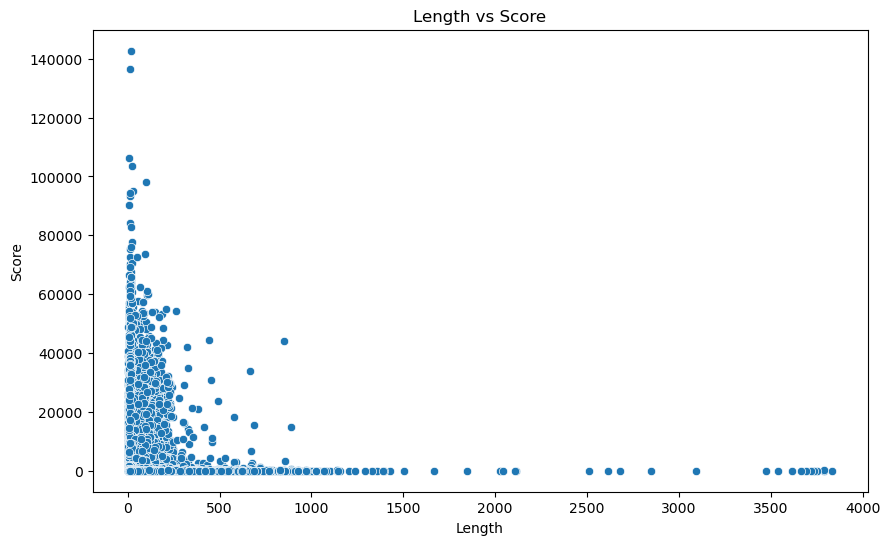

In [51]:
df['new_len'] = df['selftext'].apply(lambda x: len(x.split())) + df['title'].apply(lambda x: len(x.split()))
# Length vs Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['new_len'], y=df['score'])
plt.title('Length vs Score')
plt.xlabel('Length')
plt.ylabel('Score')
plt.show()

In [52]:
df[df['new_len'] < 350].shape[0] / df.shape[0] * 100

99.85126149065943

Which is ~0.15% of the data, so we will be removing it as it mainly consists of outliers.

In [53]:
len(df[df['score'] <= 5000]) / len(df) * 100

99.11958645817731

Which is ~1% of the data, so we will be removing it as it mainly consists of outliers.

In [54]:
# Removing outliers (length > 350) as mentioned above in the exploratory data analysis
def remove_outliers(df):
    return df[(df['new_len'] <= 350) & (df['score'] <= 5000)]

df = remove_outliers(df)
# Saving the final data
df.to_csv('dataset/outliers_removed_jokes.csv', index=False)

(-0.5, 799.5, 399.5, -0.5)

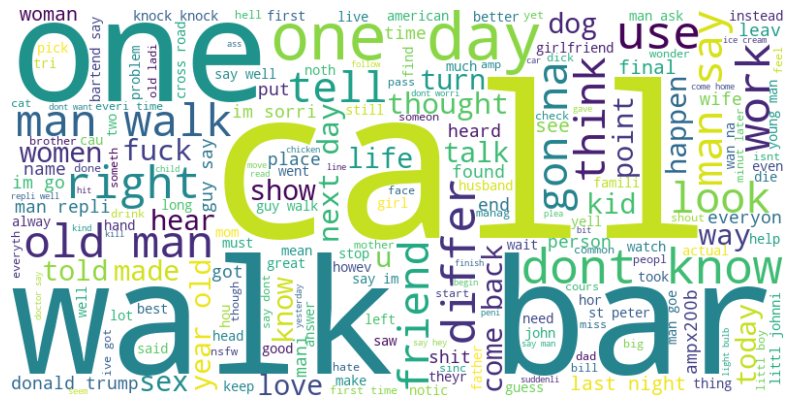

In [55]:
# Wordcloud of jokes after data cleaning
text = ' '.join(df['title'] + ' ' + df['selftext'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [56]:
df.head()

,created_utc,permalink,selftext,title,score,length,score_bins,length_bins,new_len
0,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,corona cover foreskin expos virus,soooo glad im circumcis,2,20,1-501,11-21,9
1,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,call googl sheet,know googl platform record bowel movement,9,17,1-501,11-21,9
2,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,vacuum doesnt snore sex ampx200b april fool do...,differ wife vacuum,15,24,1-501,21-31,12
7,1585784461,https://old.reddit.com/r/Jokes/comments/ftbeb4...,oolala,french man say attract teletubbi,2,11,1-501,11-21,6
10,1585784081,https://old.reddit.com/r/Jokes/comments/ftbahg...,yo momma fat went zoo hippo got jealou,yo mama,0,17,NaN,11-21,10


In [57]:
def expand_contractions(text):
    return contractions.fix(text)

# Applying to selftext and title columns
df['title'] = df['title'].apply(expand_contractions)
df['selftext'] = df['selftext'].apply(expand_contractions)

# Saving the expanded data
df.to_csv('dataset/expanded_jokes.csv', index=False)

df.head()

,created_utc,permalink,selftext,title,score,length,score_bins,length_bins,new_len
0,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,corona cover foreskin expos virus,soooo glad i am circumcis,2,20,1-501,11-21,9
1,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,call googl sheet,know googl platform record bowel movement,9,17,1-501,11-21,9
2,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,vacuum does not snore sex ampx200b april fool ...,differ wife vacuum,15,24,1-501,21-31,12
7,1585784461,https://old.reddit.com/r/Jokes/comments/ftbeb4...,oolala,french man say attract teletubbi,2,11,1-501,11-21,6
10,1585784081,https://old.reddit.com/r/Jokes/comments/ftbahg...,yo momma fat went zoo hippo got jealou,yo mama,0,17,NaN,11-21,10


In [58]:
# Remove the length bins column
df.drop(columns=['length_bins'], inplace=True)

# Remove the rows with null values
df.dropna(subset=['title'], inplace=True)
df.dropna(subset=['selftext'], inplace=True)

# Remove the rows with empty values
df = df[df['title'] != '']
df = df[df['selftext'] != '']

# Saving the final data
df.to_csv('dataset/final_jokes.csv', index=False)

# Model training

## Basline models:

### Bag of words + Linear regression

In [59]:
df['X'] = df['title'] + ' ' + df['selftext']

In [60]:
# Preparing the data for training
X = df[['X', 'new_len']]
y = df['score'].values

# Normalizing the length and score
X['new_len'] = X['new_len'] / X['new_len'].max()
Y_MAX = y.max()
y = y / Y_MAX

/var/folders/x0/z57d4n8d7x72sq50341k2p900000gn/T/ipykernel_28478/361651164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['new_len'] = X['new_len'] / X['new_len'].max()


In [69]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

vectorizer = CountVectorizer(max_features=5000)

X_bow = vectorizer.fit_transform(X['X'])

# Combining the bag of words features with the new_len feature
X_combined = hstack((X_bow, X['new_len'].values.reshape(-1, 1)))

# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Training the model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
from sklearn.metrics import mean_squared_error

print(f'MSE: {mean_squared_error(y_test, y_pred)}')

# Saving the model
import pickle

pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

MSE: 0.003500912672745954


In [70]:
y_test = y_test * Y_MAX
y_pred = y_pred * Y_MAX

In [71]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

MSE: 87522.81681864883


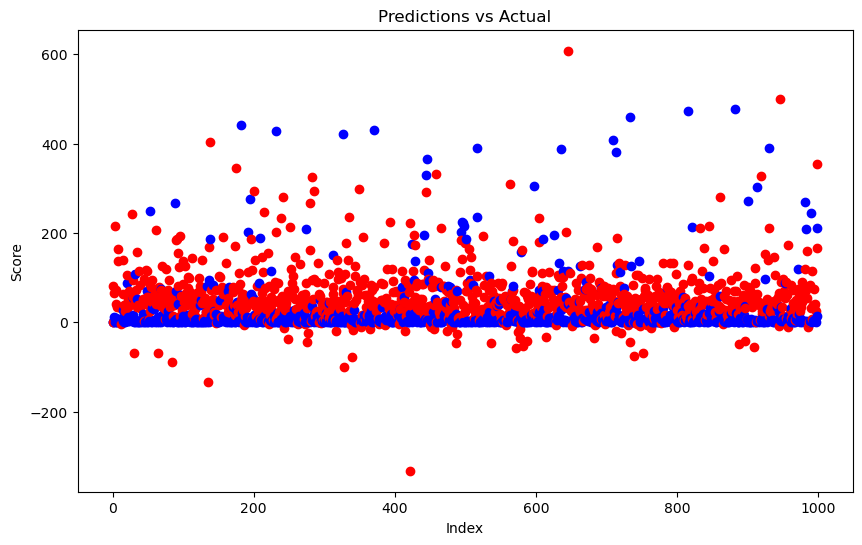

In [72]:
# Plotting the predictions

plt.figure(figsize=(10, 6))

for i in range(len(y_test[:1000])):
    if y_test[i] < 500:
        plt.scatter(i, y_test[i], color='blue')
        plt.scatter(i, y_pred[i], color='red')

plt.title('Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Score')
plt.show()

The baseline Linear Regression model is performing very poorly on the prediction task.

### TF-IDF

In [73]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_tfidf = vectorizer.fit_transform(X['X'])

# Combining the bag of words features with the new_len feature
X_combined = hstack((X_tfidf, X['new_len'].values.reshape(-1, 1)))

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Training the model
model = LinearRegression()

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

MSE: 0.0034813381199288404


In [74]:
y_test = y_test * Y_MAX
y_pred = y_pred * Y_MAX

In [75]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

MSE: 87033.452998221


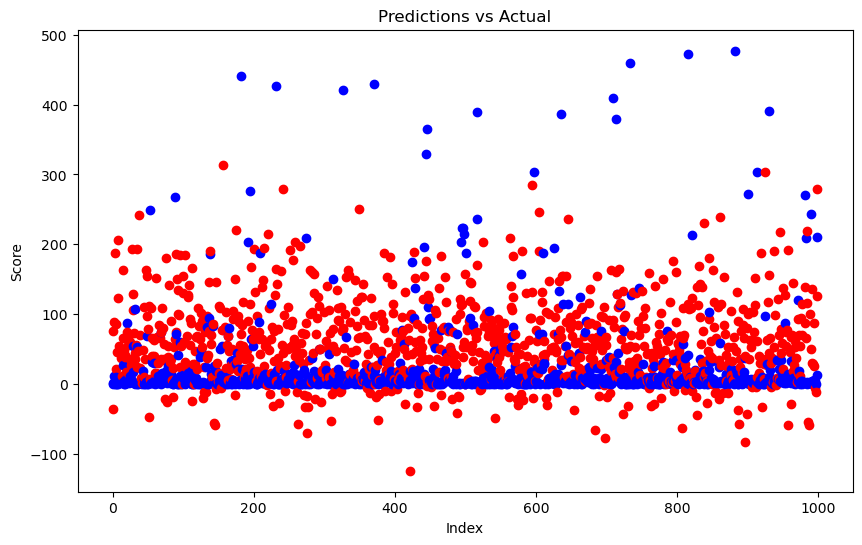

In [76]:
# Plotting the predictions

plt.figure(figsize=(10, 6))

for i in range(len(y_test[:1000])):
    if y_test[i] < 500:
        plt.scatter(i, y_test[i], color='blue')
        plt.scatter(i, y_pred[i], color='red')

plt.title('Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Score')
plt.show()

The TF-IDF model is also not performing well.